In [1]:
import torch
import time
from tqdm import tqdm
torch.cuda.is_available(), torch.cuda.current_device()

(True, 0)

# Some helping stuff 

In [2]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [3]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], labels[index]

    
    def __len__(self):
        return len(self.texts)

# Data preparations

In [4]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'sci.med'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target

In [5]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=4, shuffle=False)

# Model Definitions

In [6]:
from torch import nn

class ClusteringLayer(nn.Module):
    
    def __init__(self, initial_centroids, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.weights = nn.Parameter(initial_centroids)
        self.alpha = alpha
    
    def forward(self, inputs):
        """
        Takes a batch of input embeddings of shape (batch_size, embedding_size).
        And computes of soft clustering based in on the centroids.
        """    
        norm_squared = torch.sum((inputs.unsqueeze(1) - self.weights) ** 2, 2)
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2
        q = numerator ** power
        return q
    
    def __repr__(self):
        return str(self.weights.shape)

In [7]:
class DistilBertForClustering(nn.Module):
    
    def __init__(self, distilbert_model, initial_centroids):
        super(DistilBertForClustering, self).__init__()
        self.distilbert_model = distilbert_model
        self.initial_centroids = initial_centroids
        self.clustering_layer = ClusteringLayer(initial_centroids=initial_centroids)
        
    def target_probability_distribution(self, q):
        weight = (q ** 2) / torch.sum(q, 0)
        return (weight.t() / torch.sum(weight, 1)).t()
        
    def forward(self, inputs):
        distilbert_outputs = self.distilbert_model(**inputs)
        cls_embeddings = distilbert_outputs.last_hidden_state[:,0,:]
        
        q = self.clustering_layer(cls_embeddings)
        p = self.target_probability_distribution(q)
        return q, p

## Init distilbert model(s)

In [8]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model.to('cuda')

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [9]:
base_model = lm_model.base_model

## Obtain initial clustering in order to do initial clustering

In [10]:
from tqdm import tqdm
embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to('cuda')
    outputs = base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy()
    embeddings.append(cls_embedding)

2149it [00:20, 104.22it/s]


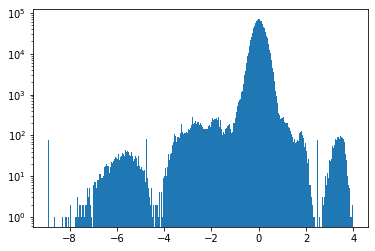

In [11]:
import matplotlib.pyplot as plt

plt.hist(np.array(embeddings).T[:].flatten(), bins=512)
plt.yscale('log')
plt.show()

## Initial clustering

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmeans_centroids = torch.from_numpy(kmeans.cluster_centers_)

kmeans_centroids = kmeans_centroids.to('cuda')
kmeans_centroids, kmeans_centroids.shape

(tensor([[-0.0712, -0.0491,  0.0697,  ..., -0.1380,  0.3239,  0.2242],
         [-0.0155,  0.0224, -0.1704,  ..., -0.0005,  0.4066,  0.3976],
         [-0.1415, -0.0496,  0.0142,  ..., -0.0641,  0.1895,  0.2586],
         [-0.1813, -0.0892,  0.0248,  ..., -0.0418,  0.3154,  0.4834]],
        device='cuda:0', dtype=torch.float64),
 torch.Size([4, 768]))

In [13]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=np.unique(labels).shape[0], covariance_type='full')
gm_cluster = gm.fit_predict(embeddings)

### Evluation as baseline for the latter

In [14]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))

0.6845044206607724
0.49862176101142586
0.4252118960261368


In [15]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(labels, gm_cluster)[1])
print(normalized_mutual_info_score(labels, gm_cluster))
print(adjusted_rand_score(labels, gm_cluster))

0.6877617496510005
0.4995262154012147
0.43233156041813925


## Init clustering model

In [16]:
cluster_model = DistilBertForClustering(distilbert_model=base_model, initial_centroids=kmeans_centroids)
cluster_model.to('cuda')

DistilBertForClustering(
  (distilbert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

## Define optimizer and loss

In [17]:
from itertools import chain
lm_optimizer = torch.optim.Adam(params=lm_model.parameters(), lr=0.00001)
cluster_optimizer = torch.optim.SGD(params=cluster_model.parameters(), lr=0.001)

In [18]:
clustering_loss_fn = nn.KLDivLoss(reduction='batchmean')

In [19]:
def kld(pred, target):
            return torch.mean(torch.sum(target*torch.log(target/(pred+1e-6)), dim=1))

In [20]:
def kl_divergence(pred, target):
    return torch.mean(torch.sum(target * torch.log(target/pred), dim=1))

## Define training loop

In [21]:
def train(epoch, t, lm_model, cluster_model, data_loader, lm_optimizer, cluster_optimizer, clustering_loss_fn):
    
    lm_model.train()
    cluster_model.train()
    
    # train part
    pbar = tqdm(data_loader)
    for batch_index, batch_data in enumerate(pbar):
        
        if batch_index % t == 0:
            pbar.set_description("Recomputing ps")
            # compute p for each batch and store it
            ps = {}
            for index, xi in enumerate(list(data_loader)[batch_index: batch_index + t]):
                texts, _ = xi
                inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True
                )
                inputs = inputs.to('cuda')
                _, p = cluster_model(inputs)
                p = p.detach()
                ps[batch_index + index] = p

        inputs = inputs.to('cuda')
        # get inputs for the models
        texts, _ = batch_data
        inputs = tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
            truncation=True
        )
        inputs = inputs.to('cuda')
        # do lm task
        outputs = lm_model(labels=inputs['input_ids'], **inputs)
        lm_loss = outputs.loss
        # do clustering task
        q, _ = cluster_model(inputs)
        #q = q.cpu().detach()
        p = ps[batch_index]
        clustering_loss = clustering_loss_fn(q, p)
        
        # do optimization step
        combined_loss = (.001 * lm_loss) + (1. * clustering_loss)
        
        lm_optimizer.zero_grad()
        cluster_optimizer.zero_grad()
        
        combined_loss.backward()
        
        lm_optimizer.step()
        cluster_optimizer.step()
        
        pbar.set_description(f'''Epoch {epoch + 1} | Combined Loss {combined_loss.item()} | Clustering Loss {clustering_loss.item()} | LM Loss {lm_loss.item()}''')
    
    # validation part
    with torch.no_grad():
        cluster_model.eval()
        true_labels = []
        predicted_labels = []
        embeddings = []
        for batch_index, batch_data in enumerate(pbar):
            texts, labels = batch_data
            inputs = tokenizer(
                texts,
                return_tensors='pt',
                padding=True,
                truncation=True
            )
            inputs = inputs.to('cuda')
            q, p = cluster_model(inputs)
            embeddings.append(
                cluster_model.distilbert_model.base_model(**inputs).last_hidden_state[:,0,:].cpu().detach().numpy()
            )
            
            predicted_label = q.argmax(dim=1).cpu().detach().numpy()
            true_label = labels.cpu().detach().numpy()
            
            predicted_labels.extend(predicted_label)
            true_labels.extend(true_label)
            
        true_labels = np.array(true_labels).flatten()
        predicted_labels = np.array(predicted_labels).flatten()

        print('#' * 60)
        print("NN Measures")
        print("NMI:", normalized_mutual_info_score(true_labels, predicted_labels))
        print("Accuracy:", cluster_accuracy(true_labels, predicted_labels))
        print("ARI:", adjusted_rand_score(true_labels, predicted_labels))
        
        print("Kmeans measures")
        embeddings = np.vstack(embeddings)
        kmeans = KMeans(n_clusters=np.unique(true_labels).shape[0], n_init=20)
        kmeans_predicted_labels = kmeans.fit_predict(embeddings)
        print("NMI:", normalized_mutual_info_score(true_labels, kmeans_predicted_labels))
        print("Accuracy:", cluster_accuracy(true_labels, kmeans_predicted_labels))
        print("ARI:", adjusted_rand_score(true_labels, kmeans_predicted_labels))
        
        return embeddings, true_labels, predicted_labels

In [ ]:
for epoch in range(1):
    embeddings, true, pred = train(
        epoch=epoch,
        t=5,
        lm_model=lm_model,
        cluster_model=cluster_model,
        data_loader=data_loader,
        lm_optimizer=lm_optimizer,
        cluster_optimizer=cluster_optimizer,
        clustering_loss_fn=kl_divergence
    )

Recomputing ps:  49%|████▉     | 265/538 [00:49<00:51,  5.33it/s]                                                                                               

In [ ]:
import matplotlib.pyplot as plt

plt.hist(embeddings.T[:].flatten(), bins=512)
plt.yscale('log')
plt.show()

In [ ]:
raise Exception("Stop here!")

In [ ]:
np.vstack(embeddings).shape
len(texts)

In [ ]:
np.unique(pred, return_counts=True), np.unique(labels, return_counts=True)

In [ ]:
# recompute embeddings
from tqdm import tqdm
tuned_embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to('cuda')
    outputs = base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy()
    tuned_embeddings.append(cls_embedding)

In [ ]:
cluster_model.distilbert_model.base_model(**inputs)

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP 

pca = UMAP(n_components=2)

Xr = pca.fit_transform(tuned_embeddings)

import seaborn as sns

sns.scatterplot(x=Xr[:,0], y=Xr[:,1], hue=[f'C{i}' for i in kmeans_cluster])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(tuned_embeddings)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))

In [ ]:
raise Exceptionception('Stop here')

In [ ]:
## backup
if batch_index % t == 0:
            pbar.set_description("Recomputing ps")
            # compute p for each batch and store it
            ps = []
            for index, b in enumerate(data_loader):
                texts, _ = b
                inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True
                )
                inputs = inputs.to('cuda')
                _, p = cluster_model(inputs)
                p = p.cpu().detach()
                ps.append(p)

In [ ]:
# test code for my training and p update strategy
data_loader = DataLoader(list(range(1000)))
t = 100
for batch_index, x in enumerate(data):
    if batch_index % t == 0:
        xs = {}
        for index, xi in enumerate(list(data_loader)[batch_index: batch_index + t]):
            xs[batch_index + index] = xi
    print(x == xs[batch_index])
    print(len(xs))

In [ ]:
from decimal import Decimal
Decimal(1e-5)

In [ ]:
torch.stack([])